# Topic 2: Uncertainty

## Associated Reading: Bishop 1.2

# 1. Overfitting
This week, we'll continue our analysis of the simple infant mortality rate that we have been working with.  Once again, we will read the data from file, drop outliers, and normalize.  However, this time, let's imagine that rather than just predicting the IMR for Venezuela, we'll try to make predictions for 1/2 of the countries on the list.  Thus, we're going to split our data into two sets: a **training set**, which we will use to adjust the parameters of (or train) our model, and a **test set**, which we will use after training to determine how well our model is at predicting things it hasn't seen before.

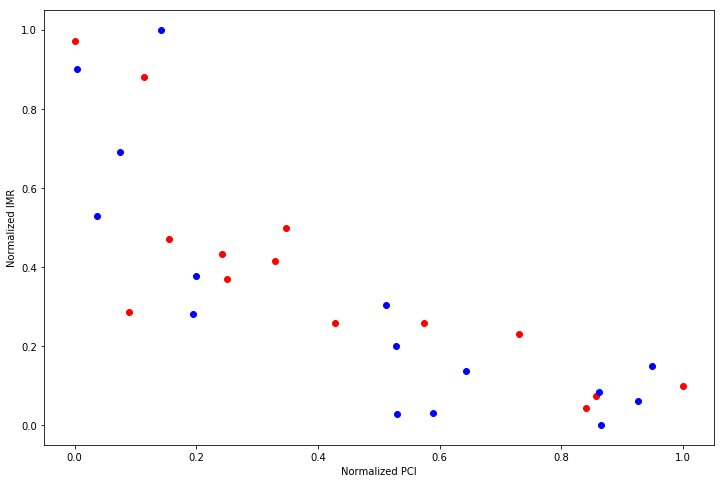

In [8]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 8)
import matplotlib.pyplot as plt

np.random.seed(17)

data = pd.read_csv('datasets/birthrate.dat',header=0,sep=r"\s{2,}",engine='python',index_col=0)
data = data.drop('United States')

pci_min = data['PCI'].min()
pci_range = data['PCI'].max() - pci_min
x = (data['PCI'] - pci_min)/pci_range

imr_min = data['Infant Mortality'].min()
imr_range = data['Infant Mortality'].max() - imr_min
y = (data['Infant Mortality'] - imr_min)/imr_range

m = len(x)
random_indices = np.random.permutation(range(m))
train_indices = random_indices[:m//2]
test_indices = random_indices[m//2:]

x_train = x[train_indices]
y_train = y[train_indices]

x_test = x[test_indices]
y_test = y[test_indices]

plt.plot(x_train,y_train,'ro')
plt.plot(x_test,y_test,'bo')
plt.xlabel('Normalized PCI')
plt.ylabel('Normalized IMR')
plt.show()

Note that our purpose from the last exercise has changed a bit: rather than predict the value of IMR for a single country, now we want to ask whether, in general, our model is good at predicting *any* country's IMR.  

In the last unit's in-class assignment, we developed some code that would allow us to fit polynomials of various complexity to these observations.  We also found that for models with many degrees of freedom (lots of parameters relative to the data), that some of the resulting fits were pretty wild.

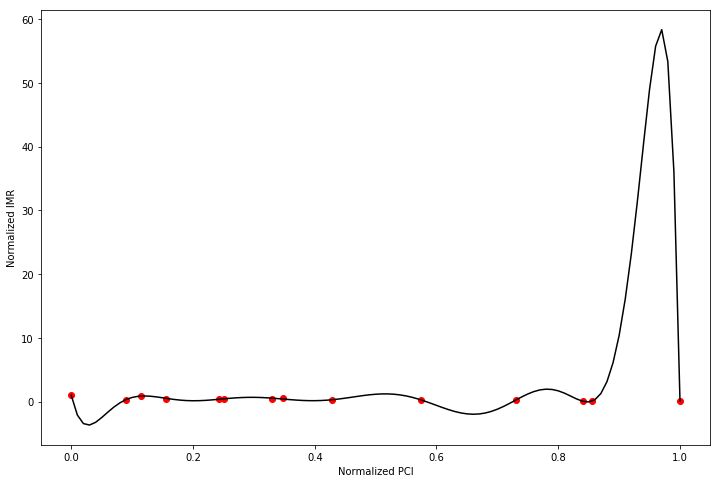

In [19]:
def fit_poly(x,y,d):
    # Fit a polynomial of degree d to the univariate data (x,y)
    # Note technically, this fits a polynomial of degree d-1 (d=1 fits a constant, d=2 a line, etc.)
    X = np.vander(x,d,increasing=True)
    w = np.linalg.solve(X.T@X,X.T@y.ravel())
    y_pred = X @ w
    return y_pred,w

def evaluate_poly(x,w):
    # For a given set of weights (e.g. the ones produced by fit_poly),
    # evaluate the model on x
    X = np.vander(x,len(w),increasing=True)
    return X @ w

def get_smooth_prediction(w,xmin=0,xmax=1):
    # The test and training data are out of order and irregularly spaced;
    # if we want to look at the resulting curves, we want to evaluate the 
    # fitted polynomial on a dataset that is smooth and dense.
    x = np.linspace(xmin,xmax,101)
    y = evaluate_poly(x,w)
    return x,y

d = len(x_train)

y_pred_train,w = fit_poly(x_train,y_train,d)
x_plotting,y_plotting = get_smooth_prediction(w)

plt.plot(x_train,y_train,'ro')
plt.plot(x_plotting,y_plotting,'k-')
plt.xlabel('Normalized PCI')
plt.ylabel('Normalized IMR')
plt.show()

Note that we're getting almost a perfect fit to the training data.  **But do we believe the predictions that these complicated models produce?** Let's come up with a strategy to find out.  How shall we quantify how well our model fits the training data?    

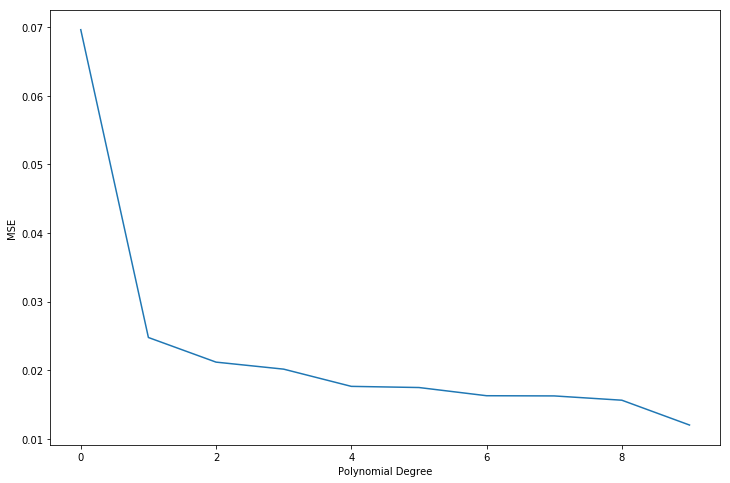

In [25]:
def get_mse(y_pred,y_obs):
    return 1./len(y_pred)*sum((y_pred-y_obs)**2)

mse_train = []
w_trained = []

for d in range(1,11):
    y_train_pred,w = fit_poly(x_train,y_train,d)
    mse_train.append(get_mse(y_train_pred,y_train))
    w_trained.append(w)
    
plt.plot(range(0,10),mse_train)
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.show()

This is great.  We get what amounts to zero error as the complexity of the model increases. 

But what about the error when it comes to predicting stuff that we didn't use to train.  We can evaluate that using the *test set* that we split off from the main dataset earlier.  In fact, we can use the same metric to quantify it.

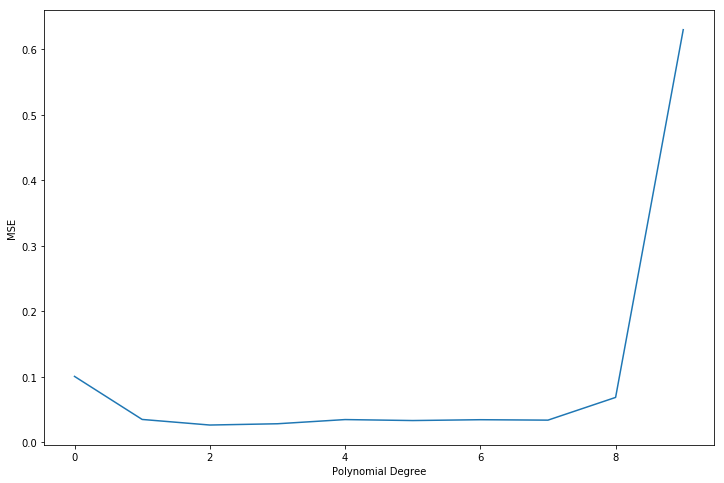

In [26]:
mse_test = []

for d,w in zip(range(1,11),w_trained):
    y_test_pred = evaluate_poly(x_test,w)
    mse_test.append(get_mse(y_test_pred,y_test))
    
plt.plot(range(0,10),mse_test)
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.show()

What if we plot both the training and test error on top of one another?

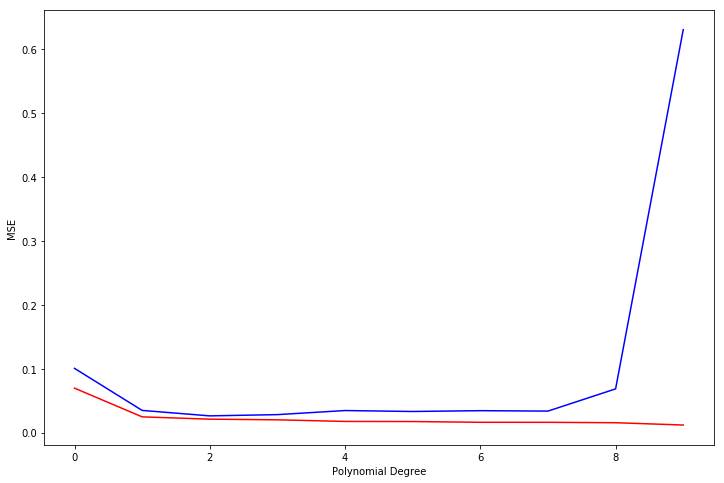

In [28]:
plt.plot(range(0,10),mse_train,'r-')
plt.plot(range(0,10),mse_test,'b-')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.show()

The model's training error continues to decline as we add more *complexity* to the model.  However, **based on the test error, is there any advantage to using a more complex model?  at what point does using a more complex model cease to be an advantage?**

Perhaps a more critical question is as follows: **What is going wrong when we use a more complex model?**

## 2.  Observational uncertainty
Taking measurements is hard.  There are many ways in which data may *not perfectly quantify the phenomenon it is supposed to be quantifying*.  Let's take the IMR, for example: there might be cultural biases against reporting, government statistics might be corrupted, or the value may have changed since it was recorded. This is called *observational uncertainty*.  (More insidiously, it is always the case that the models that we use are incorrect, though some may still be useful.  This latter reason behind why data diverge from predictions is called *structural uncertainty*, however we will ignore this for the time being).  We need our models to be robust to this kind of observational uncertainty: our fitting procedure should, in some sense, be able to ignore these observational errors and still fit the underlying quantity that the observations are imperfectly representing.  Let's experiment with how robust our polynomial models are to observational error.  

The code I provide below simulates another reality.  What do I mean by that?  Let's imagine for a moment that the error in our measurements is *random*, in the sense that our observation is just the true value of IMR corrupted by some random number.  What this code does is (for our purposes) to provide the same observations, but with that random number something different.     

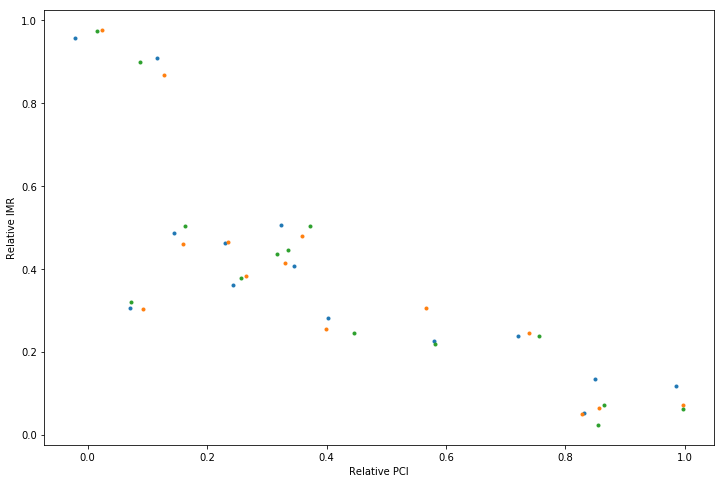

In [31]:
def get_new_y_train(sigma=0.02):
    return y_train + sigma*np.random.randn(len(y_train))

def get_new_x_train(sigma=0.02):
    return x_train + sigma*np.random.randn(len(x_train))

plt.plot(get_new_x_train(),get_new_y_train(),'.')
plt.plot(get_new_x_train(),get_new_y_train(),'.')
plt.plot(get_new_x_train(),get_new_y_train(),'.')
plt.xlabel('Relative PCI')
plt.ylabel('Relative IMR')
plt.show()

Each of the above colors represents a dataset which (very loosely speaking) is the dataset we might have collected in a different reality.  Now we can ask the question, how robust is the process of fitting a line to these errors?

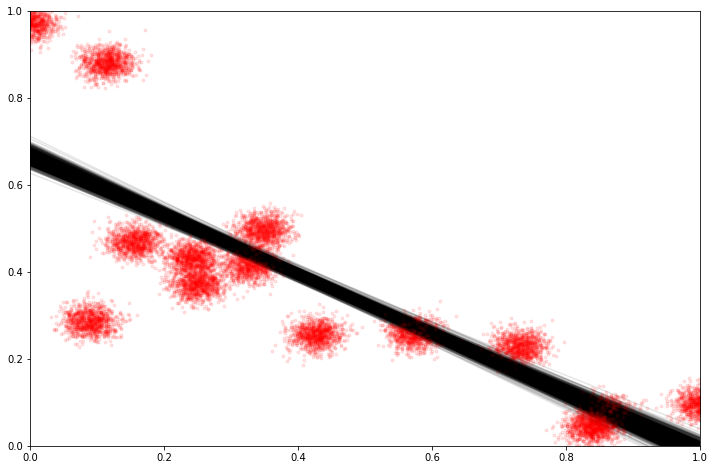

In [35]:
ws = []

for i in range(1000):
    y_train_new = get_new_y_train(sigma=0.02)
    x_train_new = get_new_x_train(sigma=0.02)
    y_train_pred,w = fit_poly(x_train_new,y_train_new,2)
    ws.append(w)
    x_plotting,y_plotting = get_smooth_prediction(w)
    plt.plot(x_train_new,y_train_new,'r.',alpha=0.1)
    plt.plot(x_plotting,y_plotting,'k-',alpha=0.1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

As it turns out, quite robust.  Let's look at the resulting slopes and intercepts.  Note that I stored the predicted weights in the above loop, so now I have 1000 instances representing what the slope and intercept might have been in a different version of reality.  A nice way to look at them is with a histogram.

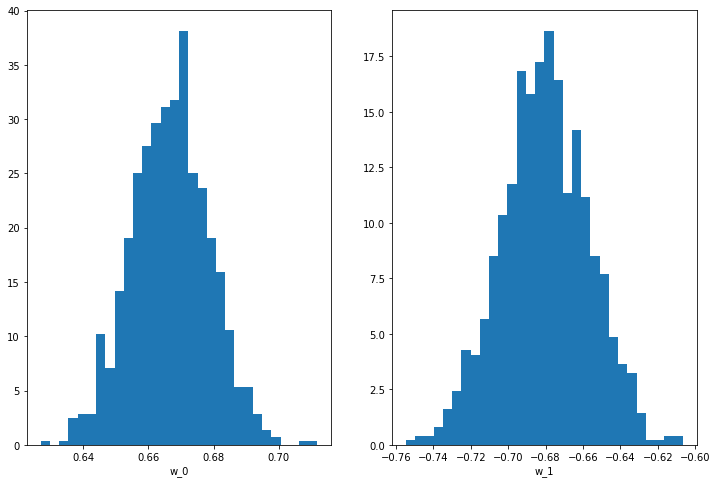

In [39]:
w_array = np.array(ws)
fig,axs = plt.subplots(nrows=1,ncols=w_array.shape[1])
for i,(ax,w) in enumerate(zip(axs,w_array.T)):
    ax.hist(w,30,density=True)
    ax.set_xlabel('w_'+str(i))

How about for a slightly more complex model?  Let's try the same process for a quadratic, which was the most complex model we were allowed to use, based on looking at where the test and training errors diverged.

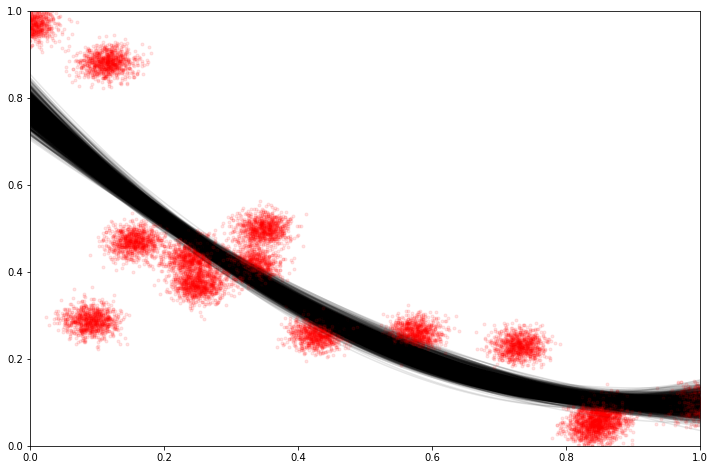

In [40]:
ws = []

for i in range(1000):
    y_train_new = get_new_y_train(sigma=0.02)
    x_train_new = get_new_x_train(sigma=0.02)
    y_train_pred,w = fit_poly(x_train_new,y_train_new,3)
    ws.append(w)
    x_plotting,y_plotting = get_smooth_prediction(w)
    plt.plot(x_train_new,y_train_new,'r.',alpha=0.1)
    plt.plot(x_plotting,y_plotting,'k-',alpha=0.1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

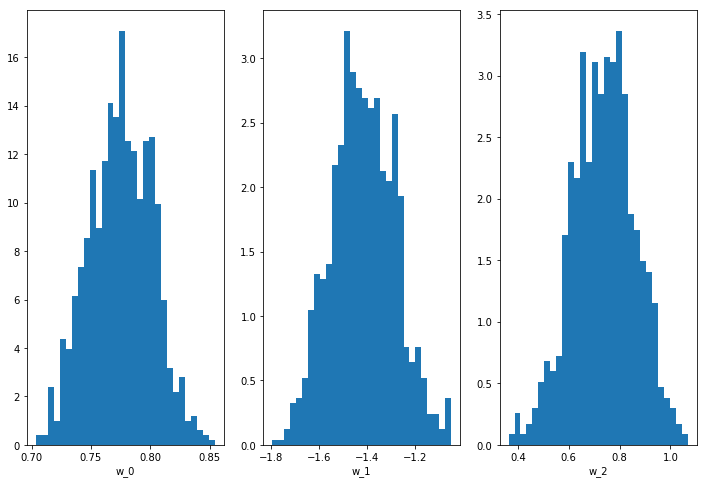

In [41]:
w_array = np.array(ws)
fig,axs = plt.subplots(nrows=1,ncols=w_array.shape[1])
for i,(ax,w) in enumerate(zip(axs,w_array.T)):
    ax.hist(w,30,density=True)
    ax.set_xlabel('w_'+str(i))

Not too wild, but notice that the width of these histograms is somewhat greater than it was for the line.  Let's try one more time, but with a much higher degree polynomial, say one with the same number of parameters as we have data points.  

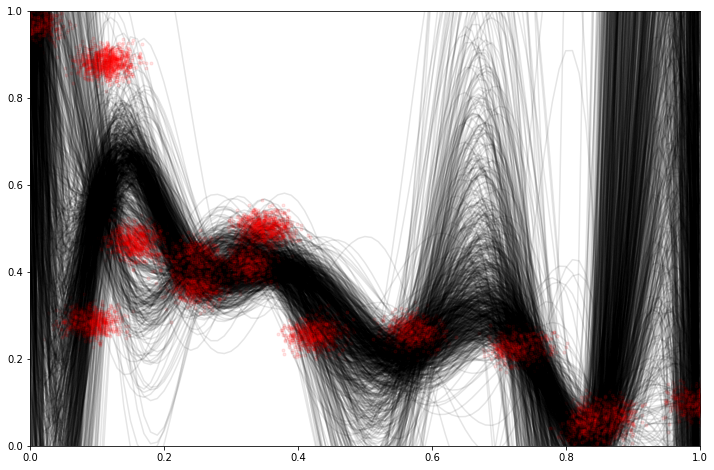

In [45]:
ws = []

for i in range(1000):
    y_train_new = get_new_y_train(sigma=0.02)
    x_train_new = get_new_x_train(sigma=0.02)
    y_train_pred,w = fit_poly(x_train_new,y_train_new,10)
    ws.append(w)
    x_plotting,y_plotting = get_smooth_prediction(w)
    plt.plot(x_train_new,y_train_new,'r.',alpha=0.1)
    plt.plot(x_plotting,y_plotting,'k-',alpha=0.1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

Now we begin to see why this model did such a poor job at making predictions on the test set: even small errors in the data lead to substantially different predictions!  And what if we wanted to have a look at the actual parameter values?

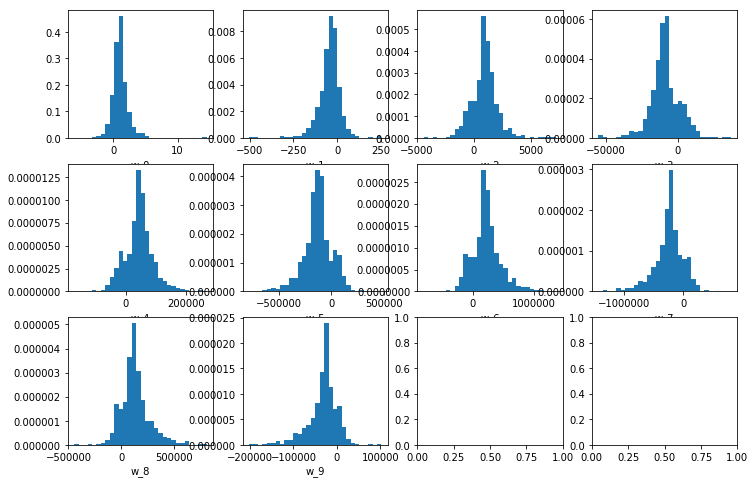

In [47]:
w_array = np.array(ws)
fig,axs = plt.subplots(nrows=3,ncols=4)
for i,(ax,w) in enumerate(zip(axs.ravel(),w_array.T)):
    ax.hist(w,30,density=True)
    ax.set_xlabel('w_'+str(i))

Now we see something very troubling.  In this case, all of the parameters have a substantial number of instances with opposing signs: the intercept, for example, could be either positive or negative.  Despite the fact that this model is able to reproduce the training data very accurately, the resulting extreme variability in parameter values leads to the conclusions that we can't really learn anything about the model itself.  This is a phenomenon called the *bias-variance tradeoff*: the more freedom we give our model to align itself with observations, larger grows the *variance* in the parameters.  

## 3. The argument for probability
The arguments presented above are *ad hoc* and based on intuition, yet the issues that we encountered are central to machine learning, in particular when answering the central question of model validation: how do know (and ensure) that our predictions are good?  In particular, the field of *Bayesian statistics* is centered around the very sensible desire to represent learned parameters as *probability distributions* rather than as single fixed values.

While that is an entire topic unto itself (and often a process too computationally expensive for practical machine learning, as we will see later), we can (and will) utilize some of its methods to ensure that we don't overfit our models.  Additionally, there are many beautiful, interesting, and profoundly useful models that are stated explicitly in terms of probability.  We will see the first of these very soon, and models in which randomness still shows up explicitly will appear throughout the course (the photorealistic faces and chatbot that we looked at on day one are formulated probabilistically).  **The procedure of learning from data must account for the fact that our knowledge of the world is imperfect!**

Fortunately for us, the probabilistic toolbox that we'll need to utilize in this course is limited: we can do amazing things with just three probabilistic identities (really two) and four probabilistic models (aka parametric probability distributions.  Also really just two).  Our next section is primarily concerned with defining these identities and models.

## 4. A definition of probability
Just as we needed to come up with an operational definition for Machine Learning, we also need a definition for what we mean by probability.  And you would think that with the ubiquity of statistics in modern society, that this would have already been settled 200 years ago.  But no, the debate continues to this day.  The two definitions are:
- (Frequentist) $p(X=x)$ is the number of times we observe that a random variable $X=x$ for an infinite number of trials, divided by the total number of trials.  For example, in the limit as $n\rightarrow \infty$, the probability of a fair coin landing on heads is 1/2, so $p(coin=heads)=0.5$.  
$$ \frac{N_{X=x}}{N_{trials}}, N_{trials}\rightarrow \infty $$
- (Bayesian) $p(X=x)$ is the degree to which we believe that for a given trial, we will observe that $X=x$.  So for $P(X=x)=1$, we're certain that $X=x$, and for $P(X=x)=0$, we're certain that this is not the case, and $P(X=x) = 0.5$, it's fifty-fifty.    

The difference probably seems totally pedantic to you right now, but it really isn't, especially in the context of machine learning or inverse problems in general.  In the case of the coin flip example, there's really not that much difference, because we can perform many repeats of the same experiment, such that we can approximate the limit as the number of trials go to infinity, and use those trials to update our probabilistic model of the coin.  However, what about trying to quantify the probability that the earth's ice sheets will have disappeared in 1000 years?  Does it make sense to define probability as "the proportion of times the ice sheets were gone in 1000 years for an infinite number of trials of the earth"?  Instead, we need a more permissive definition of probability, in which it's well defined to say "Based on some satellite measurements of ice melting, I would like to update my degree of belief in the hypothesis that the earth's ice sheets will be gone in 1000 years."  That definition is the Bayesian one, and because of this, it's become dominant in Machine Learning.

## 5. Joint probability rules
<img src="images/grid_fig.jpg" style="width: 500px;">

With probabilities defined, now it's going to be useful to understand just two basic rules of probability, and they're going to carry us a surprisingly long way.  

Since here in ML, we're interested in the relationships between input and output variables, it makes sense that these rules have to do with manipulating the probabilities of two events occurring at the same time, also known as the joint probability $P(X=x,Y=y)$.

This is most easily understood by drawing a grid in two dimensions.  On the x-axis is the random variable X, on the y-axis the random variable Y.  The divisions of these are possible values of those variables.  

### 5.1 Sum rule
So imagine, that this thing is a set of boxes, and we're randomly throwing balls into the boxes.  The probability of the ball landing in any particular box is given by the joint probability $P(X,Y)$.  In our case, we have 9 cells, so $P(X=2,Y=2) = 1/9$.  

**Now, what is $P(X=2)$?**

It is, of course, $1/3$.  This is pretty obvious, but it's instructive to write it as $P(X=2) = P(X=2,Y=1) + P(X=2,Y=2) + P(X=2,Y=3) = \sum_{i=1}^3 P(X=2,Y=y_i) = 1/3$.  $P(X=2)$ is known as the *marginal probability*, and this procedure is known as the sum rule, or generally:
$$
P(X=x_j) = \sum_{i=1}^m P(X=x_j,Y=y_i)  
$$

### 5.2 Product rule
Now let's consider cases where we're given the value of one of the random variables.  This is called *conditional probability*, annotated $P(Y=y_j|X=x_i)$.  

**If we know that $X=2$, what is the probability that $Y=2$?**

### 5.3 Exchangability 
Nothing changes if we swap the axis-labels, so $P(X=x,Y=y) = P(Y=y,X=x)$.

### 5.4 Conditional probability examples
Equipped with these probability rules, now let's use them to answer some simple questions.  To begin, Let's say that we've got two two bowls, green and blue.  Inside green, we have 1 kiwis and 3 oranges.  Inside blue, we have 3 kiwis and 1 orange.  Now what if I asked the question, whats the probability of drawing an orange if I sample from both bowls with equal likelihood?  Then we have that
\begin{align}
P(Orange) & = P(Orange,Blue) + P(Orange,Green) \\
          & = P(Orange|Blue)P(Blue) + P(Orange|Green)P(Green) \nonumber \\
        & = (1/4)(1/2) + (3/4)(1/2) = 1/2. \nonumber
\end{align}
*Note that I've simplified notation a little bit: Instead of writing P(Fruit=Orange,Bowl=Blue), I'm just writing P(Orange,Blue)*.  What if I move these three kiwis out of blue, and into green.  So now there's 1 orange in green, and 4 kiwis and three oranges in blue.  What's the probability of an orange?
\begin{align}
P(Orange) & = P(Orange,Blue) + P(Orange,Green) = P(Orange|Blue)P(Blue) \nonumber \\
          & + P(Orange|Green)P(Green) \nonumber \\
          & = (3/7)(1/2) + (1)(1/2) = 3/14 + 7/14 = 5/7
\end{align}
We are now more likely to pick a bowl with more oranges, so the overall likelihood of picking an orange goes up.  Now, what if I ask, under the same rules as above, "I picked an orange.  What is the probability that this orange came from the green bowl?".  This requires a bit more thought.  Before, we had a scenario where our conditional probabilities were determined entirely by things that we knew already.  Given a bowl color, I can tell you directly what the probability of a fruit is.  But in this case, oranges could come from either bowl, so having an orange doesn't directly determine the probability of a bowl.  Instead we need to come up with a rule for inverting probability in some way.  And this isn't very difficult using the tools we have above.  Let's start with the identity:
$$P(X=x,Y=y) = P(Y=y,X=x),$$
now apply the product rule and divide:
$$P(X=x|Y=y) = \frac{P(Y=y|X=x)P(X=x)}{P(Y=y)}$$
Now we can use this result directly:
$$P(Green|Orange) = \frac{P(Orange|Green)P(Green)}{P(Orange)} = (1)(1/2)(7/5) = 7/10$$
Because green was a sure bet for orange, and the probability of choosing green was equal to that of blue, we find that it's quite a bit more likely that the orange came from the green bowl.

### 5.5 Bayes rule
The formula that we used to compute this turns out to be so important that it has its own special proper-noun name: Bayes' Theorem.  The name is stupid by the way, it was in fact Pierre-Simon Laplace who first understood it in its modern usage and also developed some of its philosophical implications.  And once again, you're probably thinking "so what?", how does this help me do machine learning?  And the answer becomes a little bit more plain if we apply Bayes' theorem to the case of some known data $y$ and some unknown model parameters $\mathbf{w}$: 
$$P(\mathbf{w}|y) = \frac{P(y|\mathbf{w})P(\mathbf{w})}{P(y)},$$
which is to say that it provides us a statistical formula for inferring the probability distribution of model parameters given the data, which is exactly what our fundamental goal is in Machine Learning.  Even more than that, it allows us to encode what I can only describe as our suppositions about the values of those parameters in a consistent way.  So let's take a look at the anatomy of this equation.  The thing on the left is called the *posterior probability* or the probability that a given hypothesis is true after considering the data.  On the right hand side, $P(\mathbf{w})$ is called the *prior probability*, which is the probability of a hypothesis before considering the data.  The prior probability is updated according to the first term in the numerator which is called the *likelihood*, which answers the question, assuming that a particular hypothesis about $\mathbf{w}$ is true, what is the probability that we will observe the data $y$?  Finally, the denominator is often called the *evidence*, and it's the probability of observing the data under all possible hypotheses.  

### IC2A. False positives
A really classic example of Bayes' theorem in action comes from the world of disease testing.  This is a really good example because it shows the importance of the prior distribution.  So here's the problem: imagine that you're concerned that you have a rare form of cancer, something that affects 1 in 10000 people, and you go into the doctor to take a test.  The doctor tells you that the sensitivity of the test is 80%, which is to say that if you have the disease the test will read positive 80% of the time.  We also know that the test has a false positive rate of 5%.  Unfortunately, your test comes back positive.  **How concerned are you?  Use Bayes theorem to compute the probability that you actually have the disease.  Note that you have all the information you need to specify the prior, likelihood, and evidence in the above paragraph.** 

## 6 Probability distributions
In the above examples, we've been using something called a *probability table*, in which we explicitly enumerate all possible cases

| y | $P(Y=y)$   |
|------|------|
|   Orange  | 0.3 |
|   Kiwi    | 0.7 |

This table is a valid way to specify the function from $y$ to its probability.  However, in general we'd like to be able to write these tables more succinctly, particularly when the number of possible values that $y$ could take becomes very large: it's reasonable to imagine that $Y$ is real-valued.  **In that case, how many entries in the probability table would we need?**.  It's much better to *parameterize* these probabilities, which is a concept we've already seen: this is just the process of explicitly specifying a model, inputs ($y$), outputs (the probability that $Y=y$), and parameters.  Just like with the machine learning models that we've already talked about, there are many possibilities for what these models should be.  

### 6.1 The Bernoulli Distribution
One of the most common distributions, and also one that is very useful for machine learning is one that gives the probability of two mutually exclusive events.  The most common example of such a scenario is a coin flip, but, as we'll see, there are many other more interesting cases that can be modelled similarly.  This distribution is called the Bernoulli distribution, and it has the *probability mass function* 
$$ P(Y=y) = \theta^y(1-\theta)^{1-y} $$
where $y\in\{0,1\}$ indicates "success" or "failure".  **For a fair coin, what should be the value of $\theta$?  What is P(Y=1) and P(Y=0) for a fair coin?  What is the parameter that controls this function?**

### 6.1a Inferring the value of $\theta$
Now let's imagine a scenario: we are given a coin, and we want to determine whether it is loaded or not.  **How can we do this?  What would be the strategy for proceeding?**  Bayes' theorem provides a clear path forward:
$$
P(\theta|\mathbf{\hat{y}}) = \frac{P(\mathbf{\hat{y}}|\theta)P(\theta)}{P(\mathbf{\hat{y}})}
$$
Which is to say, if we have the results of some coin flips, we can *update* our belief in what $\theta$ should be.  Note that using Bayes' theorem gives us a probability distribution over $\theta$!  Rather than a single best fit value for our parameter, a full application of Bayes' Theorem lets us know how compatible all possible values of $\theta$ are with our data.  Note that this is quite similar to what we wanted for the linear regression problem: a probability distribution of parameter values.  As it turns out, doing full Bayesian inference of this type is usually pretty hard (That would be the subject of a Bayesian Statistics class).  **Instead, let's see if we can figure out a way to just find the particular value of $\theta$ that maximizes the posterior probability.**  

First, we need to specify what each of the probability distributions on the right side of Bayes' theorem are.  Let's start with the prior distribution $P(\theta)$.  Recall that this encodes our belief in what $\theta$ should be prior to having looked at any data.  Do you trust the coin flipper?  A very easy assumption, and one that will greatly simplify this particular analysis is to say that *we have no idea:* any value of $\theta$ is as likely as any other.  In so doing, we can simply say that $P(\theta)=c$, where $c$ is a constant.  Thus we now have that
$$
P(\theta|\mathbf{\hat{y}}) = \frac{c P(\mathbf{\hat{y}}|\theta)}{P(\mathbf{\hat{y}})}
$$
Now is as good a time as any to recognize a crucial fact about finding maxima: scaling by constants doesn't make a difference.  $c$ is not a function of $\theta$, so it won't actually have any effect on determining which value of $\theta$ maximizes the posterior probability.  Note however that would say the same thing about the denominator (also called the evidence): it's not a function of $\theta$, so it doesn't influence where the maximum of the posterior is with respect to $\theta$.  Thus we could simply rewrite Bayes' theorem as:
$$
P(\theta|\mathbf{\hat{y}}) \propto P(\mathbf{\hat{y}}|\theta),
$$
with the symbol $\propto$ meaning 'proportional to' or equal up to a multiplicative constant.  For the purposes of finding maxima or minima, 'proportional to' is just as good as 'equal to.'  

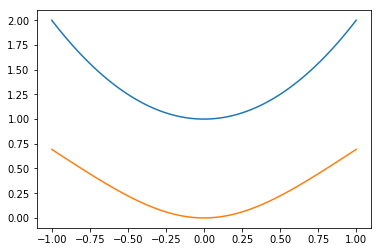

50 50


In [63]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1,1,101)
y = x**2 + 1
logy = np.log(y)
plt.plot(x,y)
plt.plot(x,logy)
plt.show()
print(np.argmin(y),np.argmin(logy))

Now, all that's left is to specify the *likelihood*.  We already know what this should be for an individual coin flip:
$$
P(Y=k|\theta) = \theta^y (1-\theta)^{1-y}.
$$
**How about for two coin flips?** 

Inferring the degree of weightedness for a coin based on a single coin flip is tenuous at best: if we really want to know, we should probably flip the coin at least twice.  If we assume that the results of the two coin flips are not directly dependent upon one another (which is to say that they are *independent*), then we can simply write this as 
$$
P(Y_1=k_1,Y_2=k_2|\theta) = P(Y_1=k_1|\theta) P(Y_2=k_2|\theta)
$$
More generally, for an arbitrary number of coin flips $m$, we have that
$$
P(\mathbf{\hat{y}}|\theta) = \prod_{i=1}^m \theta^{y_i} (1-\theta)^{1-y_i}
$$
While not easily done in general, for this simple problem we can actually plot this likelihood as a function of $\theta$ for a simulated set of coin flips.

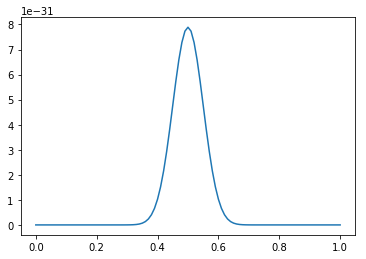

In [64]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
# random coin flips
y = np.random.randint(0,2,100)

# Array of thetas
theta = np.linspace(0,1,101)
# Array to hold the posterior values of theta
post = np.zeros_like(theta)

# for each value of theta, compute the posterior distribution
for ii,t in enumerate(theta):
    post[ii] = np.prod(t**y*(1-t)**(1-y))
    
# Plot the resulting function of theta
plt.plot(theta,post)
plt.show()

Now, we just need to find the value of $\theta$ that maximizes this function.  **How do we maximize functions?**

Unfortunately, taking derivatives of *products* is hard (think about the product rule from calculus).  It would be great to be able to change the product into a sum, which is easy to differentiate.  **What operation changes products into sums?**  Fortunately, the logarithm does just this.  Furthermore, function minima are *invariant* under log transforms! 

To maximize the posterior probability, we can alternatively look for the maximum in the log-probability with respect to $\theta$
$$\theta_{opt} = \text{argmax}_\theta \ln \left[\prod_{i=1}^m \theta^{y_i} (1-\theta)^{1-y_i}\right]$$
Taking the logarithm is pretty easy:
$$
\ln \left[\prod_{i=1}^m \theta^{y_i} (1-\theta)^{1-y_i}\right] = \sum_{i=1}^m y_i \ln \theta + (1-y_i)\ln (1-\theta)
$$
Now, all that's left is to take the derivative
$$
\frac{\partial}{\partial \theta} \left[\sum_{i=1}^m \frac{y_i}{\theta} - \frac{1-y_i}{1-\theta}\right],
$$
set it equal to zero and solve for $\theta$
$$
\theta = \frac{\sum_{i=1}^m y_i}{m}
$$

This result is the Maximum A Posteriori (or MAP) estimator for a Bernoulli model: given the data, it tells us what the most likely value for $\theta$, or alternatively, whether the coin is loaded or not.

## IC2B Implementing the MAP estimator.
Load the file class_observations.dat.  This file contains the data that was collected in last week's session.  Your task is to fit a Bernoulli distribution to the random variable of dog ownership, i.e. find the Maximum A Posteriori estimate of $\theta$ where 
$$P(\text{Owns Dog}=k|\theta) = \theta^k (1-\theta)^{1-k}$$
where $k\in\{0,1\}$.

### 6.2 The Normal Distribution
The Bernoulli distribution is extremely useful for modelling things that are binary: True or False, 1 or 0, dog or no dog.  However, there are other cases where we'd like to model things that are not binary, and indeed not even discrete.  This really underscores the necessity of parameterizing these probability models, as it would be impossible to write a probability table for a real-valued random variable, because there are infinite numbers of them!  Instead, we'll seek a distribution that gives the probability density of a real-valued distribution as a function of some parameters $P(\hat{\mathbf{y}}|\mathbf{w})$.  Note that a probability density is not exactly the same as a probability because the probability of drawing any particular real value is zero (because there are infinitely many real valued numbers).  Probability densities become probabilities when integrated over a specific range of values.  However, in general the laws of probability that we discussed above still hold for probability densities, and we will often not make much of a distinction.  

What function should we use to represent a probability density for random real valued variables.  What is an example of a random real-valued variable?  One of the most common is human height.  Let's have a look at the distribution of heights in this class.